In [35]:
# !pip install numba==0.56.0

In [83]:
import pandas as pd
import scanpy as sc
import numpy as np

# plotting tools 
import colorcet as cc
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from scDMFK.io import Clustering
# computation
from sklearn.preprocessing import StandardScaler
# from scDMFK.io import get_embedding, draw_umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

In [146]:
def get_embedding(data):
    """ Function to compute the UMAP embedding"""
    data_scaled = StandardScaler().fit_transform(data)

    embedding = umap.UMAP(n_neighbors=10,
                            min_dist=0.5,
                            metric='correlation').fit_transform(data_scaled)
    return embedding


class Clustering():
    def __init__(self, adata, dataname, denoise_method, 
                label, transpose=False, random_seed=None, mode=['raw','denoise'],
                show_plot=False):
        self.adata = adata
        self.dataname = dataname
        self.denoise_method = denoise_method
        self.label = label
        self.transpose = transpose
        self.mode = mode
        self.random_seed = random_seed
        self.show_plot = show_plot
        self.n_clusters = len(np.unique(self.label))
        if not isinstance(self.random_seed, list):
            self.random_seed = [self.random_seed]
        
        self.datasets = []
        if 'raw' in self.mode:
            self.datasets.append(adata.raw.X.T if self.transpose else adata.raw.X) # raw data
        if 'denoise' in self.mode:
            self.datasets.append(adata.X.T
                                if self.transpose else adata.X) # denoised data
        if 'latent' in self.mode:
            self.datasets.append(adata.obsm['X_hidden'].T if self.transpose else adata.obsm['X_hidden']) # latent repre
        
        result = []
        self.embeddings = []
        self.fignames = []
        for mode, data in zip(self.mode, self.datasets):
            for seed in self.random_seed:
            
                print("seed: %d  Evaluating clustering results for %s data..." % (seed, mode))
                
                ari, nmi, sc, embedding = self.calculate_cluster_results(data, mode, seed)
                result.append([self.dataname, self.denoise_method, mode, seed, ari, nmi, sc])
                figname = '-'.join(str(s).lower() for s in [self.denoise_method, mode, seed]) + '.png'
                self.fignames.append(figname)
                self.embeddings.append(embedding)
                
        self.output = np.array(result)
        self.output = pd.DataFrame(self.output, 
                            columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
    
    def get_output(self):
        return self.output
    
    def get_umap(self,method=None, mode=None, seed=None, same_figure=False, output_dir=None):
        search = lambda string, key: True if string is None else any([str(s) in key for s in string])
        inds = [
            (search(method, name) and search(mode, name) and search(seed, name)) for name in self.fignames]
        from itertools import compress
        
        embeddings = list(compress(self.embeddings, inds))
        fignames = list(compress(self.fignames,inds))
        
        if same_figure:
            self.draw_multiple_umap(embeddings, fignames, output_dir)
        else:
            for figname, emb in zip(fignames, embeddings):
                self.draw_umap(emb, figname, output_dir)
            
            
    def calculate_cluster_results(self, data, name, seed):
        if not isinstance(data, np.ndarray):
            data = np.array(data)
        
        if seed is not None:
            np.random.seed(seed) #set random seed for reproducible results

        # get UMAP 2-D embedding
        embedding = get_embedding(data)
        # K-means for clustering umi embedings
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=10).fit(embedding)
        labels = kmeans.labels_

        # Calculate metrics
        ari = adjusted_rand_score(self.label, labels)
        nmi = normalized_mutual_info_score(self.label, labels)
        sc = silhouette_score(embedding, labels)
        print(f'Adjusted Rand Index: {ari}')
        print(f'Normalized Mutual Information: {nmi}')
        print(f'Silhouette Coefficient: {sc}')
        
        return ari, nmi, sc, embedding

    def draw_umap(self, embedding, figname, output_dir=None, figsize=(15, 10), labelsize=12):  
        label = self.label

        palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
        fig, ax = plt.subplots(figsize=figsize)

        plt.xlim([np.min(embedding[:, 0]) - 0.5, np.max(embedding[:, 0]) + 1.5])
        plt.ylim([np.min(embedding[:, 1]) - 0.5, np.max(embedding[:, 1]) + 0.5])
        plt.xlabel('UMAP 1', fontsize=labelsize)
        plt.ylabel('UMAP 2', fontsize=labelsize)
        plt.title(figname[:-4])

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=label, 
                    hue_order=list(np.unique(label)), palette=palette)
        leg = plt.legend(prop={'size': labelsize}, loc='upper right', markerscale=2.00)
        leg.get_frame().set_alpha(0.9)
        plt.setp(ax, xticks=[], yticks=[])
        plt.show()
        if output_dir is not None:
            import os
            fig.savefig(os.path.join(output_dir, figname))
    
    def draw_multiple_umap(self, embedding, names=None, output_dir=None, labelsize=14):
        label = self.label
    
        if not isinstance(embedding, list):
            embedding = [embedding]
        names = [names for i in range(len(embedding))] if names is None else [s[:-4] for s in names]
        
        palette = sns.color_palette(cc.glasbey, n_colors=len(np.unique(label)))
        fig, ax = plt.subplots(1, len(embedding), figsize=(len(embedding)*12.5, 10))

        for (i, embed), figname in zip(enumerate(embedding), names):
            ax[i].set_xlim([np.min(embed[:, 0]) - 0.5, np.max(embed[:, 0]) + 1.5])
            ax[i].set_ylim([np.min(embed[:, 1]) - 0.5, np.max(embed[:, 1]) + 0.5])
            ax[i].set_xlabel('UMAP 1', fontsize=labelsize)
            ax[i].set_ylabel('UMAP 2', fontsize=labelsize)
            ax[i].set_title(figname)
            ax[i].spines['right'].set_visible(False)
            ax[i].spines['top'].set_visible(False)
            
            sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=label, 
                        hue_order=list(np.unique(label)), palette=palette, ax=ax[i])
            leg = ax[i].legend(prop={'size': labelsize}, loc='upper right', markerscale=2.00)
            leg.get_frame().set_alpha(0.9)
            plt.setp(ax[i], xticks=[], yticks=[])
        
        plt.show()
        if output_dir is not None:
            import os
            fig.savefig(os.path.join(output_dir, self.denoise_method+'-results.png'))

## 1. Endoderm Cells

In [174]:
## example using 
dataset = 'endoderm-1000'
end_label = pd.read_csv('data/endoderm/cell_label.csv').label # true labels

mode = ['raw', 'denoise']
random_seed = 1111
end_1000_multinom = sc.read('results/' + dataset + '/results-multinomial.h5ad')
end_1000_zinb = sc.read('results/' + dataset + '/results-zinb.h5ad')

cluster_result = pd.DataFrame(columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
for data, dn_method in zip([end_1000_multinom,end_1000_zinb], ['multinomial','zinb']):
    cluster = Clustering(adata=data, dataname=dataset,
                    denoise_method=dn_method, 
                    label=end_label, random_seed=random_seed, mode=mode)
    result = cluster.get_output()

    cluster_result = pd.concat([cluster_result, result])
cluster_result
    

seed: 1111  Evaluating clustering results for raw data...


Adjusted Rand Index: 0.4101426013071593
Normalized Mutual Information: 0.49061146710439885
Silhouette Coefficient: 0.38815873861312866
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.5238532869019413
Normalized Mutual Information: 0.6734776670214973
Silhouette Coefficient: 0.5525627732276917
seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.3828905406610902
Normalized Mutual Information: 0.47620377709225814
Silhouette Coefficient: 0.3853566646575928
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.39558951540965503
Normalized Mutual Information: 0.5049295297632053
Silhouette Coefficient: 0.47641077637672424


,data,denoise method,mode,random seed,ARI,NMI,SC
0,endoderm-1000,multinomial,raw,1111,0.4101426013071593,0.49061146710439885,0.38815874
1,endoderm-1000,multinomial,denoise,1111,0.5238532869019413,0.6734776670214973,0.5525628
0,endoderm-1000,zinb,raw,1111,0.3828905406610902,0.47620377709225814,0.38535666
1,endoderm-1000,zinb,denoise,1111,0.39558951540965503,0.5049295297632053,0.47641078


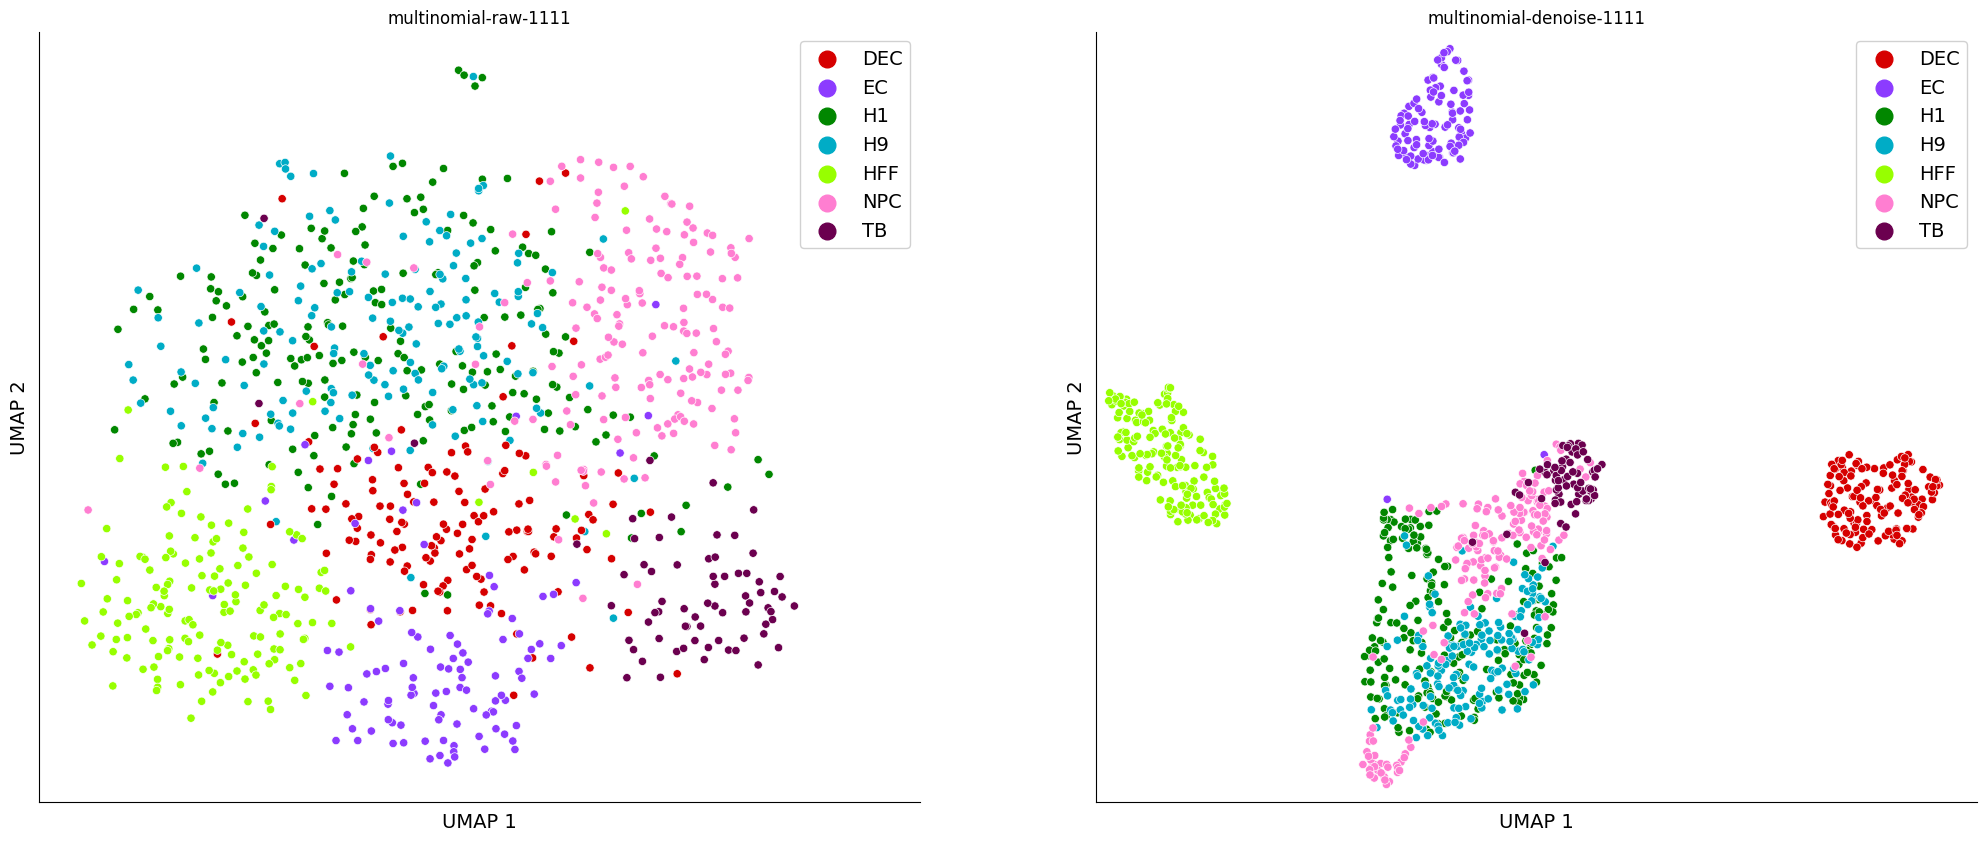

In [172]:
multinom_cluster.get_umap(same_figure=True)

In [175]:
dataset = 'endoderm'
# true labels
end_label = pd.read_csv('data/'+dataset+'/cell_label.csv').label 

# endoderm subsets
num_genes = [500,1000,5000,10000]
data_folders = [dataset] + [dataset + '-%s'%n_genes for n_genes in num_genes]
denoise_methods = ['multinomial', 'zinb', 'weight mse','mask mse']
mode = ['raw', 'denoise']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

cluster_result = pd.DataFrame(columns=["data", "denoise method", "mode", "random seed", "ARI", "NMI", "SC"])
for dn_method in denoise_methods:
    for data in data_folders:
        df_dn = sc.read('results/' + data + '/results-%s.h5ad' %dn_method )
        cluster = Clustering(adata=df_dn, dataname=data,label=end_label, 
                        denoise_method=dn_method, 
                        random_seed=random_seed[:5], mode=mode)

        result = cluster.get_output()
        cluster_result= pd.concat([cluster_result, result])
cluster_result
        

seed: 1111  Evaluating clustering results for raw data...


Adjusted Rand Index: 0.6055332178891343
Normalized Mutual Information: 0.7567677265714411
Silhouette Coefficient: 0.5553233623504639
seed: 2222  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.5951712417227256
Normalized Mutual Information: 0.7484081465703816
Silhouette Coefficient: 0.5617596507072449
seed: 3333  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6048385393125677
Normalized Mutual Information: 0.7460285362131035
Silhouette Coefficient: 0.5596623420715332
seed: 4444  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6186017168135023
Normalized Mutual Information: 0.7586061182165209
Silhouette Coefficient: 0.5447055697441101
seed: 5555  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.6313422750791814
Normalized Mutual Information: 0.7604157377582147
Silhouette Coefficient: 0.5583828687667847
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.7946826677325431
N

,data,denoise method,mode,random seed,ARI,NMI,SC
0,endoderm,multinomial,raw,1111,0.6055332178891343,0.7567677265714411,0.55532336
1,endoderm,multinomial,raw,2222,0.5951712417227256,0.7484081465703816,0.56175965
2,endoderm,multinomial,raw,3333,0.6048385393125677,0.7460285362131035,0.55966234
3,endoderm,multinomial,raw,4444,0.6186017168135023,0.7586061182165209,0.54470557
4,endoderm,multinomial,raw,5555,0.6313422750791814,0.7604157377582147,0.55838287
...,...,...,...,...,...,...,...
5,endoderm-10000,mask mse,denoise,1111,0.5210377351205422,0.6718777538066518,0.47468743
6,endoderm-10000,mask mse,denoise,2222,0.5609571052529555,0.7057368695220657,0.48049527
7,endoderm-10000,mask mse,denoise,3333,0.5326130794314744,0.6989878978298708,0.52947843
8,endoderm-10000,mask mse,denoise,4444,0.5912919014757432,0.7072670470121836,0.48261154


In [185]:
# cluster_result.to_csv('results/endoderm_cluster_results.csv', index=False)
cluster_result[['ARI','NMI','SC']] = cluster_result[['ARI','NMI','SC']].astype('float32')
cluster_result.groupby(by=['data','denoise method', 'mode']).mean()

ARI       NMI        SC
data           denoise method mode                                 
endoderm       mask mse       denoise  0.519912  0.666489  0.470588
                              raw      0.600554  0.743125  0.553837
               multinomial    denoise  0.896968  0.930787  0.629462
                              raw      0.611097  0.754045  0.555967
               weight mse     denoise  0.338011  0.503719  0.487288
                              raw      0.597636  0.743163  0.550119
               zinb           denoise  0.613835  0.737685  0.553529
                              raw      0.608750  0.748374  0.553632
endoderm-1000  mask mse       denoise  0.366713  0.554243  0.453663
                              raw      0.414910  0.488802  0.394946
               multinomial    denoise  0.520548  0.669482  0.576035
                              raw      0.416422  0.490409  0.390417
               weight mse     denoise  0.158278  0.273269  0.479862
                              raw      0.401437  0.475715  0.389388
               zinb           denoise  0.395128  0.502729  0.477251
                              raw      0.411787  0.491103  0.387227
endoderm-10000 mask mse       denoise  0.555052  0.695021  0.491322
                              raw      0.622584  0.755008  0.578615
               multinomial    denoise  0.645940  0.807895  0.575726
                              raw      0.638873  0.759914  0.577893
               weight mse     denoise  0.549068  0.674722  0.512726
                              raw      0.628093  0.759051  0.583338
               zinb           denoise  0.715680  0.830656  0.593745
                              raw      0.616495  0.754982  0.581494
endoderm-500   mask mse       denoise  0.066687  0.112265  0.617448
                              raw      0.131254  0.188331  0.351846
               multinomial    denoise  0.422335  0.544481  0.503702
                              raw      0.125489  0.183283  0.353399
               weight mse     denoise  0.056631  0.108013  0.504350
                              raw      0.128350  0.184219  0.350651
               zinb           denoise  0.202229  0.292971  0.394632
                              raw      0.128980  0.184864  0.355483
endoderm-5000  mask mse       denoise  0.469150  0.617424  0.504179
                              raw      0.720280  0.806317  0.577266
               multinomial    denoise  0.696562  0.832784  0.594707
                              raw      0.720397  0.805934  0.573406
               weight mse     denoise  0.515714  0.667533  0.540460
                              raw      0.718014  0.804804  0.579986
               zinb           denoise  0.686304  0.805251  0.567351
                              raw      0.723148  0.811713  0.568077

In [187]:
# data_files = ['endoderm','Quake_10x_Bladder','Quake_10x_Limb_Muscle','Quake_10x_Spleen','Young']
# full endoderm dataset
data = 'endoderm'
end_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')
end_zinb = sc.read('results/' + data + '/results-zinb.h5ad')
end_wmse = sc.read('results/' + data + '/results-weight mse.h5ad')
end_mmse = sc.read('results/' + data + '/results-mask mse.h5ad')

In [194]:
denoise_method = 'multinomial' # 'zinb', 'multinom'
mode = ['raw', 'denoise', 'latent']
random_seed = [1111,2222,3333,4444,5555,6666,7777,8888,9999,10000]

# true labels
label = [label.split("_")[0] for label in end_zinb.obs_names.to_list()]

# zinb = Clustering(adata=end_zinb, dataname='endoderm', denoise_method=denoise_method, 
#                     label=end_label, random_seed=1111, mode=['raw','denoise'])
multinom = Clustering(adata=end_wmse, dataname='endoderm', denoise_method=denoise_method, 
                    label=end_label, random_seed=1111, mode=['raw','denoise'])

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: 0.5851645114429023
Normalized Mutual Information: 0.7300125820887902
Silhouette Coefficient: 0.5507649183273315
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: 0.32227314641284205
Normalized Mutual Information: 0.5053340478672439
Silhouette Coefficient: 0.5229212641716003


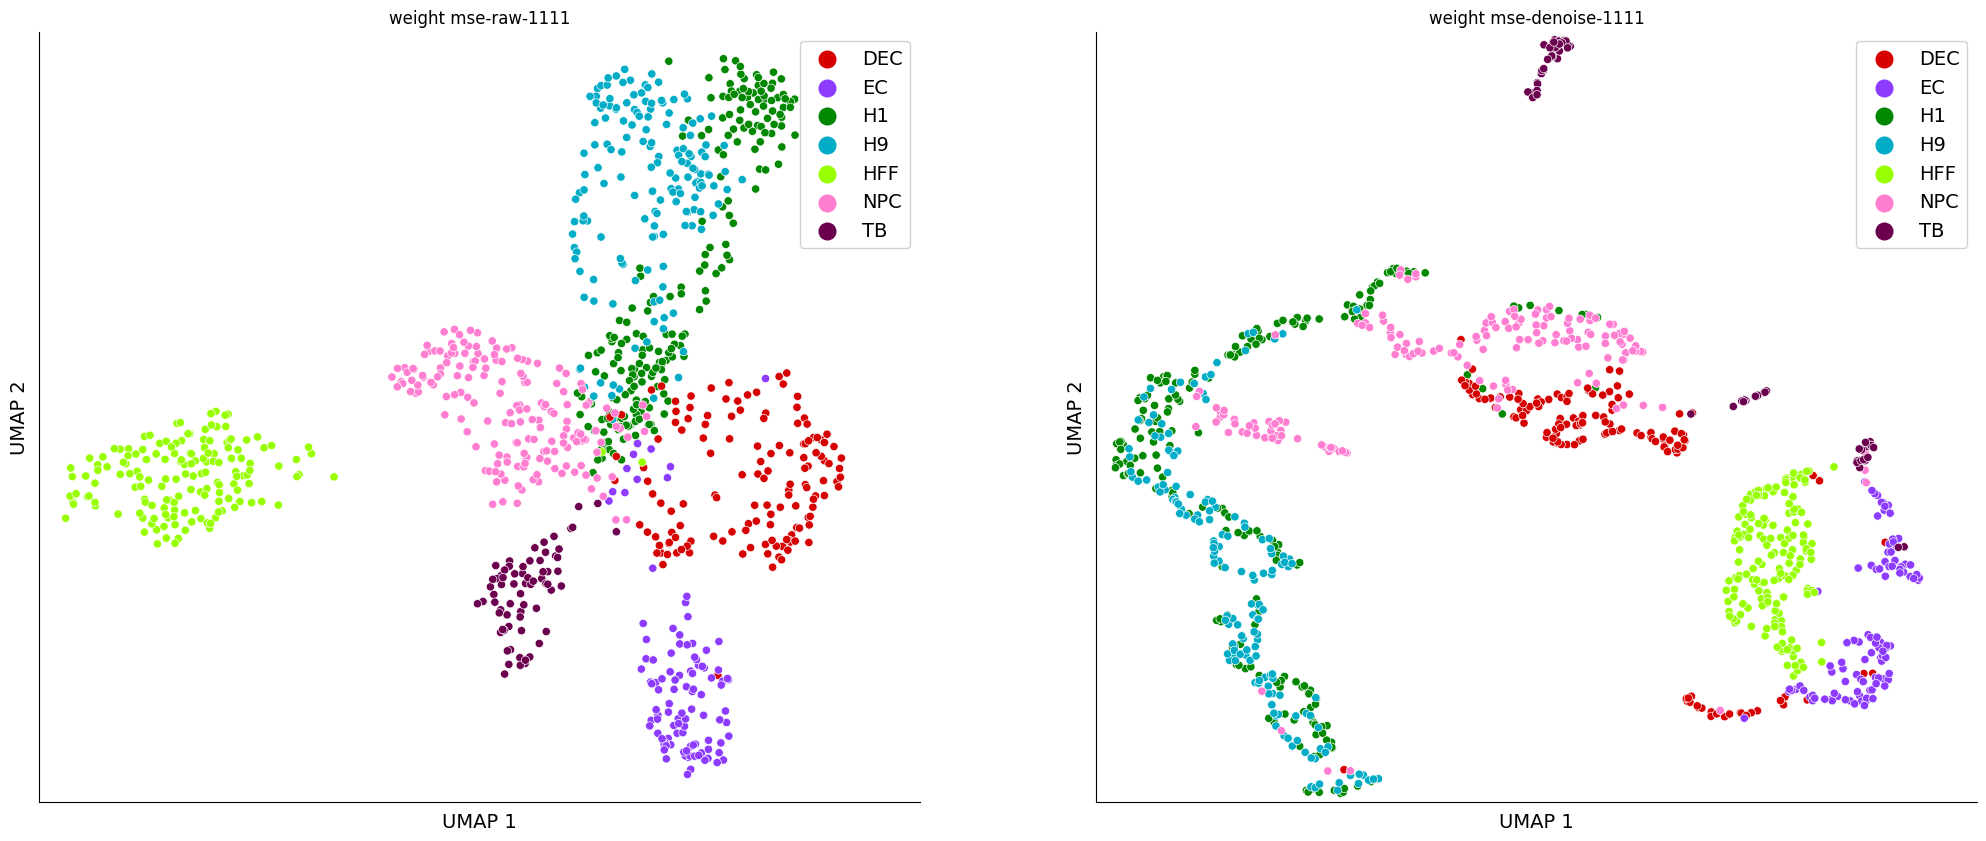

In [195]:
wmse.get_umap(same_figure=True)

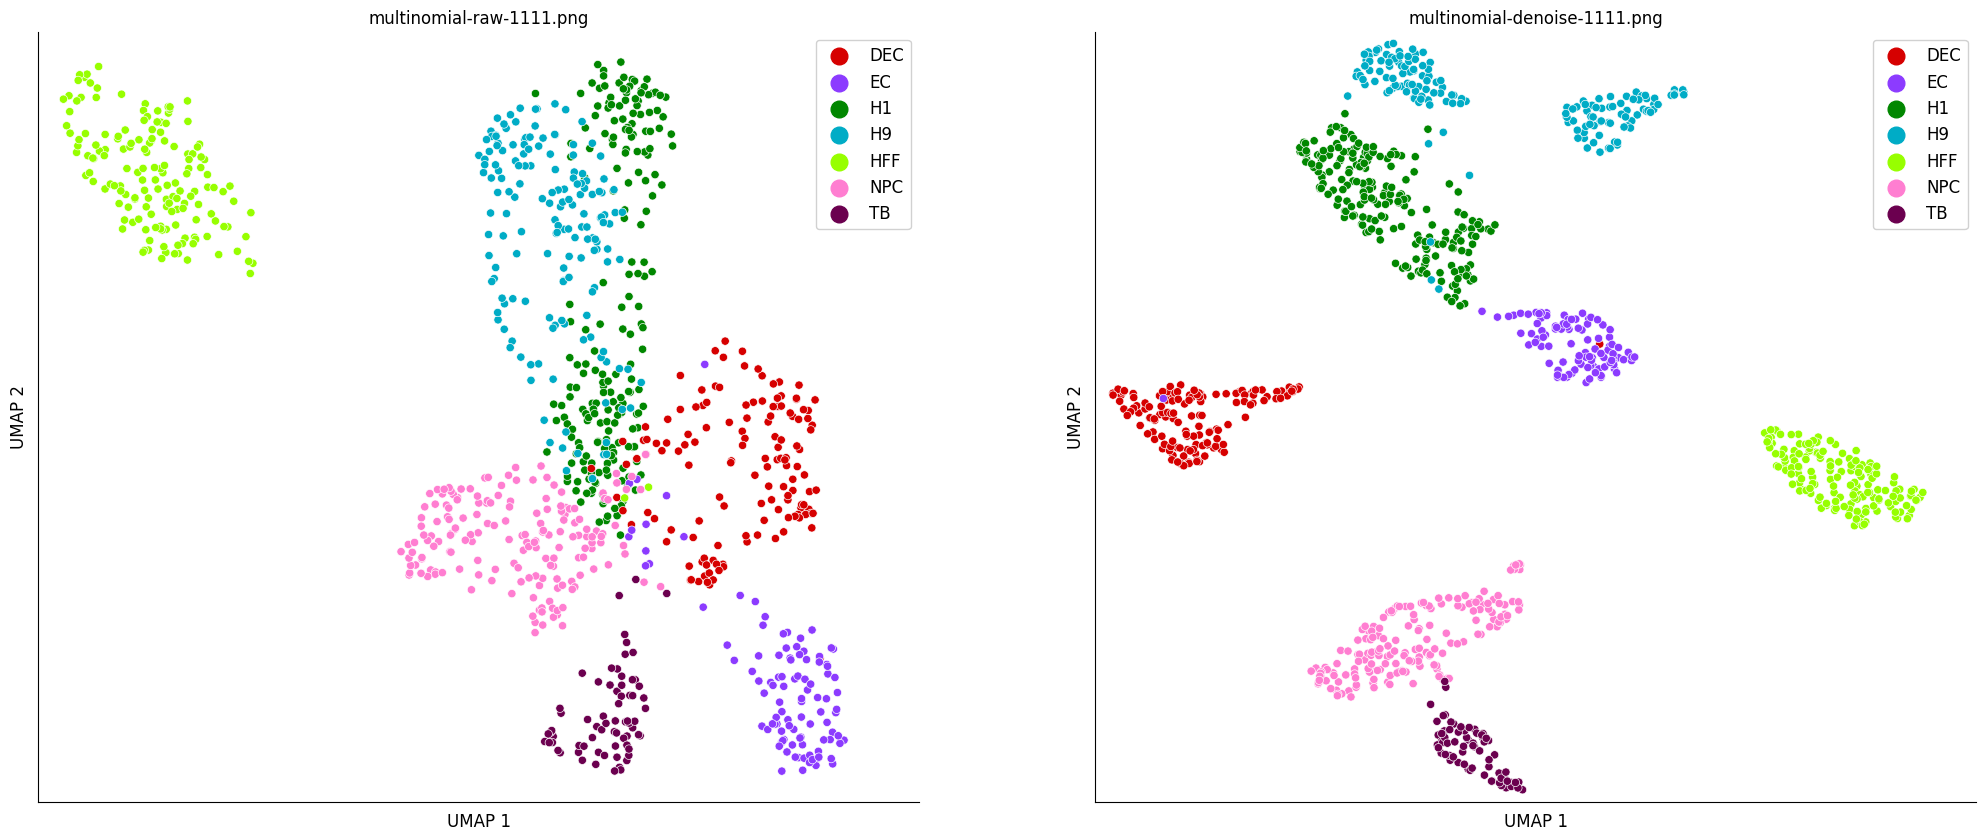

In [32]:
multinom_results = multinom.get_output()
multinom_results
multinom.get_umap(same_figure=True, output_dir='results/endoderm')

In [207]:
## simulated data
denoise_method = 'multinomial' # 'zinb', 'weight mse', 'mask mse'
mode = ['raw', 'denoise', 'latent']

data = 'group2_dropout5'
sim_multinom = sc.read('results/' + data + '/results-multinomial.h5ad')

# true labels
sim_label= pd.read_csv('data/'+ data + '/info_cellinfo.tsv', sep='\t')['Group']

multinom = Clustering(adata=sim_multinom, dataname=data, denoise_method=denoise_method, 
                    label=sim_label, random_seed=1111, mode=['raw','denoise','latent'])
multinom.get_output()

seed: 1111  Evaluating clustering results for raw data...
Adjusted Rand Index: -0.00013905687635389966
Normalized Mutual Information: 0.00025560735899150317
Silhouette Coefficient: 0.34878966212272644
seed: 1111  Evaluating clustering results for denoise data...
Adjusted Rand Index: -0.0004513701264184015
Normalized Mutual Information: 2.041372474599505e-05
Silhouette Coefficient: 0.4076411724090576
seed: 1111  Evaluating clustering results for latent data...
Adjusted Rand Index: 0.00028414819441866727
Normalized Mutual Information: 0.0005505268941158129
Silhouette Coefficient: 0.5156005024909973


,data,denoise method,mode,random seed,ARI,NMI,SC
0,group2_dropout5,multinomial,raw,1111,-0.00013905687635389966,0.00025560735899150317,0.34878966
1,group2_dropout5,multinomial,denoise,1111,-0.0004513701264184015,2.041372474599505e-05,0.40764117
2,group2_dropout5,multinomial,latent,1111,0.00028414819441866727,0.0005505268941158129,0.5156005


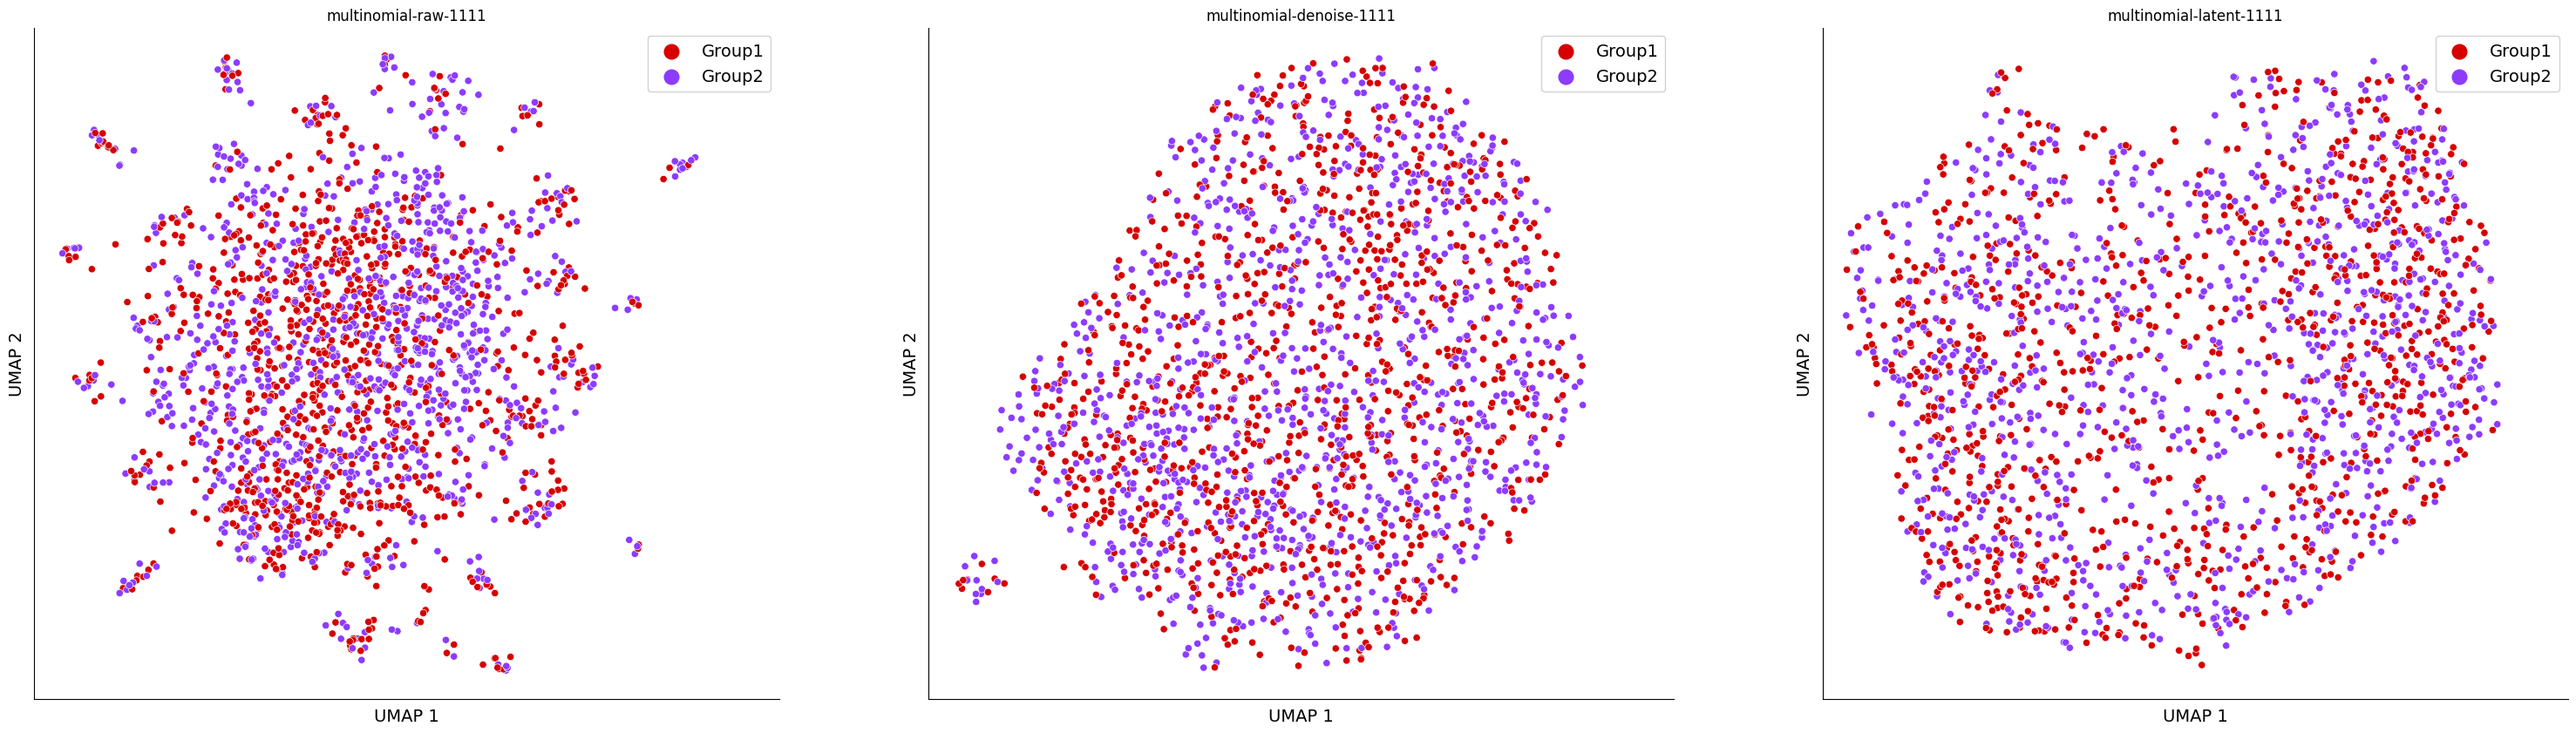

In [208]:
multinom.get_umap(same_figure=True)

In [209]:
## simulated data
denoise_method = 'dca' #'multinomial', 'zinb', 'weight mse', 'mask mse'
mode = ['raw', 'denoise']

data = 'group2_dropout5'
sim_raw = pd.read_csv('data/' + data + 'counts.tsv', sep='\t')
sim_dca = sc.read('results/' + data + '/mean.tsv', )
sim_dca = anndata.AnnData(X: sim_dca,
                          raw.X: sim_raw
                        obs: sim_dca.columns,
                        var: sim_dca.index)
sim_dca = 
# # true labels
# sim_label= pd.read_csv('data/'+ data + '/info_cellinfo.tsv', sep='\t')['Group']

# multinom = Clustering(adata=sim_multinom, dataname=data, denoise_method=denoise_method, 
#                     label=sim_label, random_seed=1111, mode=['raw','denoise','latent'])
# multinom.get_output()

AnnData object with n_obs × n_vars = 195 × 2000